In [1]:
# need to do this before transformer imports
import os
#os.environ['HF_HOME'] = '/workspace/cache/huggingface/'

import os
os.chdir('/home/wwu/')
from models.utils import *
from models.bigram_model import *
from models.mlp_model import *
from models.future_model import *
from data.utils import get_tokenizer, MODEL_NAME_DICT
import datasets
from torch.utils.data import DataLoader
from torch import nn
from itertools import islice
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer
from datasets import Dataset
from torch import nn

from tqdm import tqdm
import pandas as pd
import gc
from glob import glob
import numpy as np
import copy
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
#model_name = #'mistralai/Mistral-7B-v0.1'
MODEL = 'MISTRAL'
model_name = MODEL_NAME_DICT[MODEL]

In [3]:
model = get_model(model_name).to('cuda')

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
Token = {v: k for k, v in tokenizer.get_vocab().items()}
test = datasets.load_from_disk(f'/home/wwu/msmarco_mistral_test').with_format('torch', device=torch.device('cuda'))
loader = DataLoader(test, batch_size=128)

In [6]:
torch.set_grad_enabled(False)
gc.collect()
torch.cuda.empty_cache()

In [7]:
batches = 10
test_iter = islice(iter(loader), batches)
norm_diff = 0
norm_cum = 0
norm_avg_diff = 0 # avg along token sequence
norm_avg_cum = 0
for batch in tqdm(test_iter, total=batches):
    out = model(
        input_ids=batch['input_ids'],
        attention_mask=batch['attention_mask'],
        labels=batch['input_ids'],
        output_hidden_states=True
    )
    h = torch.stack(out.hidden_states)
    diff = torch.diff(
        h, n=1, dim=0, 
        prepend=torch.zeros(out.hidden_states[0].shape).unsqueeze(0).to('cuda')
    )
    norm_cum += h.norm(dim=3).sum(dim=1) / 128 # batch dim
    norm_diff += diff.norm(dim=3).sum(dim=1) / 128
    norm_avg_cum += h.mean(dim=2).norm(dim=2).sum(dim=1) / 128
    norm_avg_diff += diff.mean(dim=2).norm(dim=2).sum(dim=1) / 128
norm_cum /= batches
norm_diff /= batches
norm_avg_cum /= batches
norm_avg_diff /= batches

100%|██████████| 10/10 [00:08<00:00,  1.25it/s]


In [8]:
cmap = plt.get_cmap('viridis', 64)

In [90]:
plt.rgb2hex(cmap(0))

AttributeError: module 'matplotlib.pyplot' has no attribute 'rgb2hex'

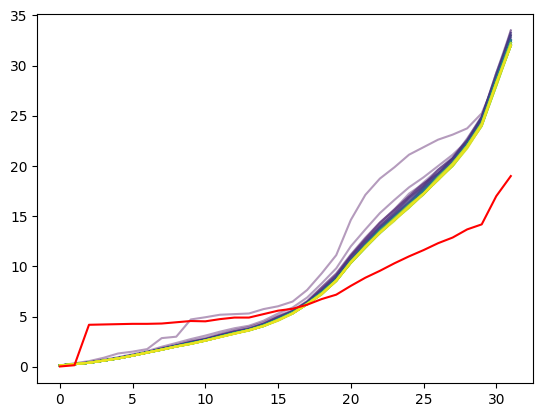

In [12]:
for i in range(1, 64): # 0th token has big norm??
    plt.plot(
        norm_cum[:-1,i].cpu().type(torch.float).numpy(),  # top layer has big norm
        color=cmap(i),
        alpha=0.4,
    )
plt.plot(norm_avg_cum[:-1].cpu().type(torch.float).numpy(), color='r')
plt.show()

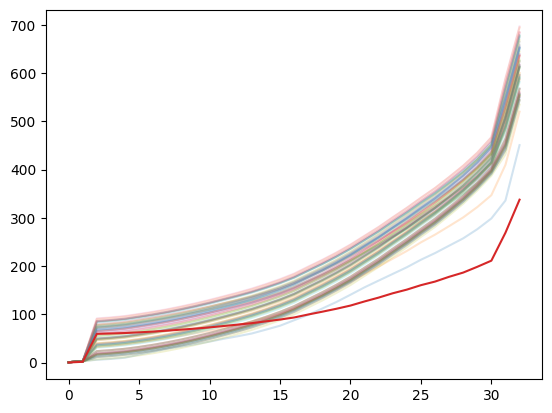

In [69]:
for i in range(1, 64): # 0th token has big norm??
    plt.plot(norm_diff[:,i].cumsum(dim=0).cpu().type(torch.float).numpy(), alpha=0.2) # top layer has big norm
plt.plot(norm_avg_diff[:].cumsum(dim=0).cpu().type(torch.float).numpy())
plt.show()

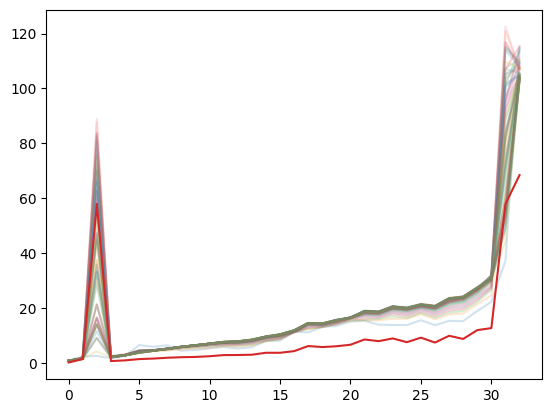

In [70]:
for i in range(1, 64): # 0th token has big norm??
    plt.plot(norm_diff[:,i].cpu().type(torch.float).numpy(), alpha=0.2) # top layer has big norm
plt.plot(norm_avg_diff[:].cpu().type(torch.float).numpy())
plt.show()

In [32]:
h.shape

torch.Size([33, 128, 64, 4096])

In [43]:
norm_cum.cpu().type(torch.float).numpy()

array([[1.4355469e-01, 1.4550781e-01, 1.3867188e-01, ..., 1.3378906e-01,
        1.3476562e-01, 1.3183594e-01],
       [6.0000000e+00, 3.5156250e-01, 2.9687500e-01, ..., 2.6562500e-01,
        2.6562500e-01, 2.6367188e-01],
       [2.6800000e+02, 5.6640625e-01, 4.6875000e-01, ..., 4.0234375e-01,
        4.0234375e-01, 4.0039062e-01],
       ...,
       [2.7000000e+02, 2.8625000e+01, 2.8250000e+01, ..., 2.8250000e+01,
        2.8250000e+01, 2.8250000e+01],
       [2.3800000e+02, 3.3500000e+01, 3.2500000e+01, ..., 3.2000000e+01,
        3.2250000e+01, 3.2000000e+01],
       [3.4000000e+02, 3.9400000e+02, 3.8600000e+02, ..., 3.6800000e+02,
        3.6800000e+02, 3.6800000e+02]], dtype=float32)

In [46]:
norm_avg_cum.shape

torch.Size([33])

In [91]:
diff.shape

torch.Size([33, 128, 64, 4096])

In [92]:
out.logits.shape

torch.Size([128, 64, 32000])

In [101]:
nn.CrossEntropyLoss(reduction='none')(
    out.logits.transpose(1, 2),
    batch['input_ids'],
    #torch.softmax(out.logits, dim=2).transpose(1, 2)
).shape

torch.Size([128, 64])

In [99]:
batch['input_ids'].shape

torch.Size([128, 64])

In [62]:
class LitBigram(L.LightningModule):
    def __init__(self, model_name, lr=1e-4):
        super().__init__()
        self.model_name = model_name
        model = get_model(model_name, precision='32')
        self.embed = model.model.embed_tokens
        self.unembed = model.lm_head
        for param in self.embed.parameters():
            param.requires_grad=False
        for param in self.unembed.parameters():
            param.requires_grad=False
        self.save_hyperparameters()
        self.linear = nn.Linear(
            self.embed.embedding_dim,
            self.unembed.in_features
        )
        self.lr=lr

    def forward(self, batch):
        return self.unembed(self.linear(self.embed(batch['input_ids'])))

    def _compute_loss(self, batch):
        out = self.forward(batch)
        return nn.CrossEntropyLoss()(
            out.transpose(1, 2)[:,:,:-1],
            batch['input_ids'][:,1:],
        )
    def training_step(self, batch, batch_idx):
        return self._compute_loss(batch)

    def validation_step(self, batch, batch_idx):
        loss = self._compute_loss(batch)
        print('val loss', loss)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        return self._compute_loss(batch)

    def configure_optimizers(self):
        return optim.Adam(params=self.linear.parameters())

In [56]:
bigram = LitBigram.load_from_checkpoint(
    '/home/wwu/mistral_bigram.ckpt',
    strict=False
).to('cuda').type(torch.bfloat16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [144]:
batches = 10
test_iter = islice(iter(loader), batches)
model_surps = []
model_confs = []
bigram_surps = []
bigram_confs = []
diff_norms = []
self_attns = []
prev_attns = []
futr_attns = []
idxs = []
for batch in tqdm(test_iter, total=batches):
    '''
    diff_norm: sum of norm of between-layer differences per token
    bigram_surp: bigram loss against label
    bigram_conf: bigram output distribution entropy
    model_surp: model loss against label
    model_conf: model output entropy
    self_attn: token attn weight for self, avg across heads and layers
    futr_attn: avg of other token's attn weight against this one, avg across heads and layers
    prev_attn: avg of this token's attn weight against others, avg across heads and layers
    idx: index in sequence
    
    Throw out first token (b/c attn weights are abnormally high)
    and last token (b/c we don't have loss for last)
    '''
    out = model(
        input_ids=batch['input_ids'],
        attention_mask=batch['attention_mask'],
        labels=batch['input_ids'],
        output_hidden_states=True,
        output_attentions=True,
    )
    h = torch.stack(out.hidden_states)
    diff = torch.diff(
        h, n=1, dim=0, 
        prepend=torch.zeros(out.hidden_states[0].shape).unsqueeze(0).to('cuda')
    )
    diff_norm = diff.norm(dim=3).sum(dim=0)[:,1:-1]
    diff_norms.append(diff_norm)
    model_conf = nn.CrossEntropyLoss(reduction='none')(
        out.logits.transpose(1, 2)[:,:,1:-1],
        torch.softmax(out.logits, dim=2).transpose(1, 2)[:,:,1:-1]
    )
    model_surp = nn.CrossEntropyLoss(reduction='none')(
        out.logits.transpose(1, 2)[:,:,1:-1],
        batch['input_ids'][:,2:],
    )
    # NOTE: for Mistral, 0th hidden state is just embedded tokens. Not nec true for other models, eg GPT2
    bigram_out = bigram.unembed(bigram.linear(out.hidden_states[0]))
    bigram_conf = nn.CrossEntropyLoss(reduction='none')(
        bigram_out.transpose(1, 2)[:,:,1:-1],
        torch.softmax(bigram_out, dim=2).transpose(1, 2)[:,:,1:-1]
    )
    bigram_surp = nn.CrossEntropyLoss(reduction='none')(
        bigram_out.transpose(1, 2)[:,:,1:-1],
        batch['input_ids'][:,2:]
    )
    attn = out.attentions
    # cut first and last from attn
    #attn = [x[:,:,1:-1,1:-1] for x in attn]
    self_attn = sum([x.diagonal(dim1=2, dim2=3).mean(dim=1) for x in attn])[:,1:-1] / len(attn)
    idx_desc = torch.range(attn[0].shape[-1]-1, 0, -1).to('cuda')
    idx_asc = torch.range(0, attn[0].shape[-1]-1).to('cuda')
    # this is tricky -- avg is over lower triangle
    futr_attn = sum([
        ((x.sum(dim=2) - x.diagonal(dim1=2, dim2=3)) / idx_desc).mean(dim=1) for x in attn
    ])[:,1:-1] / len(attn)
    prev_attn = sum([
        ((x.sum(dim=3) - x.diagonal(dim1=2, dim2=3)) / idx_asc).mean(dim=1) for x in attn
    ])[:,1:-1] / len(attn)
    bigram_surps.append(bigram_surp)
    bigram_confs.append(bigram_conf)
    model_surps.append(model_surp)
    model_confs.append(model_conf)
    self_attns.append(self_attn)
    futr_attns.append(futr_attn)
    prev_attns.append(prev_attn)
    idxs.append(idx_asc[1:-1].broadcast_to(prev_attn.shape))
    

100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


In [145]:
stats = torch.stack(
    [
        torch.concat([a.flatten() for a in x], dim=0)
        for x in [
            idxs, 
            diff_norms, 
            bigram_confs, 
            bigram_surps, 
            model_confs, 
            model_surps, 
            self_attns, 
            prev_attns,
            futr_attns,
        ]
    ],
    dim=1
)

In [146]:
stats = stats.cpu().numpy()

In [147]:
names = [
    'idx', 
    'diff_norm', 
    'bigram_conf', 
    'bigram_surp', 
    'model_conf', 
    'model_surp', 
    'self_attn', 
    'prev_attn',
    'futr_attn',
]

In [148]:
stats.mean(axis=0)

array([3.1500000e+01, 4.4920813e+02, 5.6414261e+00, 5.3752704e+00,
       2.0788569e+00, 2.1630948e+00, 3.8887244e-02, 7.2473004e-02,
       1.0364093e-02], dtype=float32)

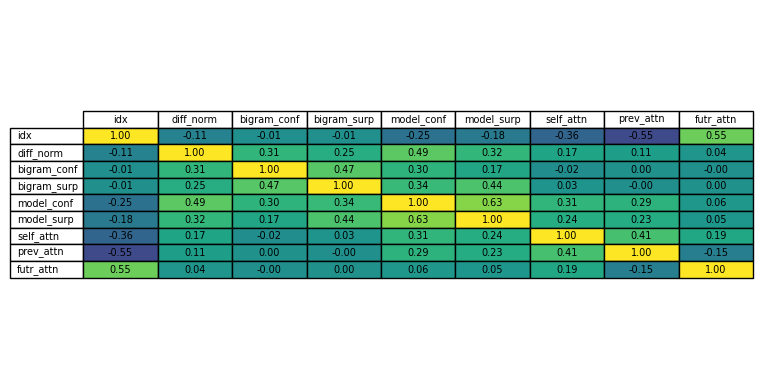

In [149]:
corr = np.corrcoef(stats.T)
corr_str = np.vectorize(lambda x: f'{x:.2f}')(corr)

fig, ax = plt.subplots()
table = ax.table(
    cellText=corr_str, 
    loc='center', 
    cellLoc='center', 
    colWidths=[0.15 for _ in range(len(corr))],
    colLabels=names,
    rowLabels=names,
)

for i in range(len(corr)):
    for j in range(len(corr[0])):
        color = plt.cm.viridis((1 + corr[i][j]) / 2)
        table[(i+1, j)].set_facecolor(color)
ax.axis('off')
plt.show()

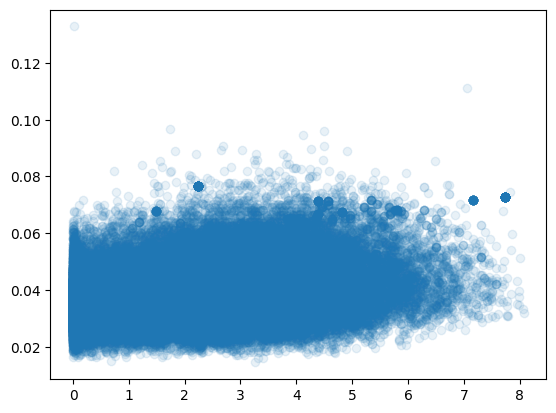

In [92]:
plt.scatter(stats[:,4], stats[:,6], alpha=0.1)
plt.show()

In [154]:
from scipy.stats import pearsonr
pearsonr(stats[:,1], stats[:,4])

PearsonRResult(statistic=0.08322467017503568, pvalue=6.65505084073087e-124)

In [155]:
model

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )
    (norm): MistralRMSNorm()
  

In [160]:
model.model.embed_tokens.embedding_dim

4096

In [171]:
for i in range(32):
    print(list(model.model.layers[i].post_attention_layernorm.parameters())[0].mean())

tensor(0.4160, device='cuda:0', dtype=torch.bfloat16)
tensor(0.6055, device='cuda:0', dtype=torch.bfloat16)
tensor(0.7734, device='cuda:0', dtype=torch.bfloat16)
tensor(0.9336, device='cuda:0', dtype=torch.bfloat16)
tensor(1.0156, device='cuda:0', dtype=torch.bfloat16)
tensor(1.1406, device='cuda:0', dtype=torch.bfloat16)
tensor(1.2266, device='cuda:0', dtype=torch.bfloat16)
tensor(1.3359, device='cuda:0', dtype=torch.bfloat16)
tensor(1.4062, device='cuda:0', dtype=torch.bfloat16)
tensor(1.4375, device='cuda:0', dtype=torch.bfloat16)
tensor(1.4609, device='cuda:0', dtype=torch.bfloat16)
tensor(1.5078, device='cuda:0', dtype=torch.bfloat16)
tensor(1.6172, device='cuda:0', dtype=torch.bfloat16)
tensor(1.7109, device='cuda:0', dtype=torch.bfloat16)
tensor(1.7812, device='cuda:0', dtype=torch.bfloat16)
tensor(1.9219, device='cuda:0', dtype=torch.bfloat16)
tensor(2.0938, device='cuda:0', dtype=torch.bfloat16)
tensor(2.2656, device='cuda:0', dtype=torch.bfloat16)
tensor(2.4062, device='cuda: